# Multiresolution Decomp/Fourier Analysis comparison

## Fiber Optic Cable and Eddy-Covariance Observations

#### To Do
- Basic statistical comparison of EC $T_{air}$ observations and FOC DTS observations.
- Find segment of FOC vertical harp (Ultima) with the highest correlation with the ECObs (since we did not actually measure which bin is closest... whoops)
- Fourier analysis of FOC and ECObs
- Compare Fourier analysis to MRD
- Expand to include comparison with XT

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirPrint = dirPre + 'graphics'
dirProcessedEC = dirPre + 'data/land_station_eddycovar_2m_processed/'
dirProcessedUltima = dirPre + 'data/DTS_UltimaVHSRE_processed'

In [67]:
# ------------------------------------------------------------------------------------------
# Load processed 2m land station eddy covariance data
os.chdir(dirProcessedEC)
ecObs = xr.open_dataset('VHRSE.eddyCovarObs_2m_land.Raw.nc')

# Mask and remove NaN's, create efficient arrays for processing.
sonic1 = np.ma.masked_array(ecObs.S1_Ts, (np.isnan(ecObs.S1_Ts))
                            | (ecObs.S1_Ts > 100) | (ecObs.S1_Ts < -30)).compressed()
sonic2 = np.ma.masked_array(ecObs.S2_Ts, (np.isnan(ecObs.S2_Ts))
                            | (ecObs.S2_Ts > 100) | (ecObs.S2_Ts < -30)).compressed()

## Multiresolution Decomposition

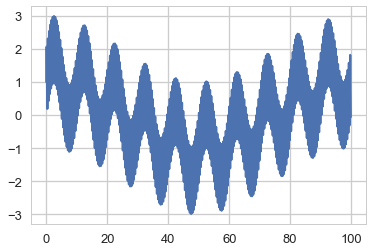

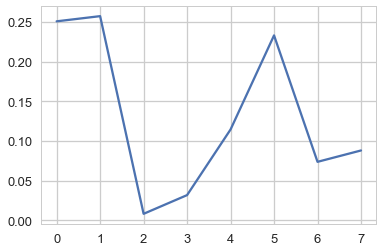

In [80]:
# Create a synthetic signal to use in both matlab and python
x = np.arange(0, 100, 0.1)
signal = np.sin(1/5 * np.pi * x) + np.sin(np.pi * 5 * x) + np.cos(1/50 * np.pi * x)
totalModes = 8
plt.plot(x, signal)

def multires_2var(a, b, M): 
    # Force deep copies of the a and b containers in case we are passing the same variable for both
    import copy
    a = copy.copy(a)
    b = copy.copy(b)
    
    # Preallocate matrices
    avg_a = np.ones((M + 1, 2**M))
    avg_b = np.ones((M + 1, 2**M))
    D = np.ones((M)) * -9999

    for inverseModeNum in np.arange(M + 1, dtype='int'):
        modeNum = M - inverseModeNum
        # Length of the decomposition mode window
        windowLength = 2**modeNum
        # Number of the decomposition mode windown
        windowNum = (2**M) / windowLength
        # Sum of the decomposition modes (for power spectrum)
        sumab = 0

        for windex in np.arange(windowNum, dtype='int'):
            # Window indices for summing
            startIndex = (windex * windowLength)
            endIndex = (windex * windowLength) + windowLength

            # Sums over the entire window length
            za = np.mean(a[startIndex:endIndex])
            zb = np.mean(b[startIndex:endIndex])

            # Store avg
            avg_a[inverseModeNum, windex] = za
            avg_b[inverseModeNum, windex] = zb

            # Sums covariance due to window means
            sumab = sumab + za * zb

            # Removes window avg for next modes
            a[startIndex:endIndex] = a[startIndex:endIndex] - za
            b[startIndex:endIndex] = b[startIndex:endIndex] - zb

        if windowNum > 1:
            # Highest mode does not count towards spectral power (single sample)
            D[modeNum] = sumab / windowNum
    return(avg_a, avg_b, D)

avg_a, avg_b, D = multires_2var(signal, signal, 8)
plt.figure()
plt.plot(D)

# FINALLY

The python and MATLAB versions produce identical output for the synthetic function. There were 2 problems:
- I reversed the `inverseModeNum` and `modeNum` indexers
- Python was doing shallow copies of the signal argument, leading to the function removing the mean twice from both a and b. Frustrating. So now I force the function to do deep copies. It is unclear to me if this would be necessary if the MRD was part of a standalone library rather than an in-script defined function.

In [84]:
# Run MRD for DTS and sonic
numScales = 11
numHours = 5
scales = 2**(np.arange(numScales))
tIndexBeg = np.arange(0, (numHours) * 3600, 3600)
spectraEC = np.zeros((numScales, len(tIndexBeg)))

for tNum, beg in enumerate(tIndexBeg):
    mrd_length = beg + 2 ** numScales
    end = int(beg + mrd_length) + 1
    if end > len(ecObs.time):
        end = len(ecObs.time)
    signal1 = sonic1[int(beg): end]
    avg, _, spectraEC1 = multires_2var(signal1, signal1, numScales)

    signal2 = sonic2[int(beg): end]
    avg, _, spectraEC2 = multires_2var(signal2, signal2, numScales)


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(0.00025717773437499824, 1)

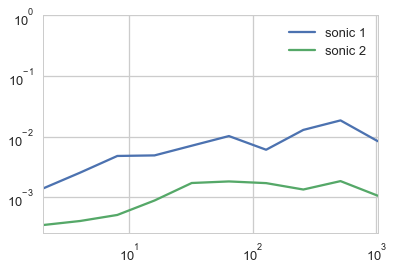

In [85]:
plt.subplots(1, 1)
plt.plot(scales, spectraEC1, label='sonic 1')
plt.plot(scales, spectraEC2, label='sonic 2')

# Format
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().legend()
# Remove first mode since it corresponds to a second
plt.gca().set_xlim(scales[1], scales[-1])
plt.gca().set_ylim(0, 1)

### MRD 
- Simply scaled the spectra to themselves.
- I am not convinced I am calculating the MRD correctly.
- Number of hours of data used: 5ish
- Data with a strong linear trend should have much more power at the longer frequencies, correct?